## Prodigy Task 5
Task 5 : Develop a model that can accurately recognize food items from images and estimate their calorie content, enabling users to track their dietary intake and make infored food choice.

In [2]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
!tar xzvf food-101.tar.gz

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/695879.jpg
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/

In [31]:
!pip install matplotlib-venn

In [32]:
!apt-get -qq install -y libfluidsynth1

E: Package 'libfluidsynth1' has no installation candidate


In [34]:
import os
import shutil
import stat
import seaborn as sns
import collections
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.image as img
import random
import cv2
import PIL

In [36]:
import matplotlib.pyplot as plt
import matplotlib.image as img
from os import listdir
from os.path import isfile, join
from collections import defaultdict
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from sklearn.model_selection import train_test_split
from skimage.io import imread
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
from shutil import copy
from shutil import copytree, rmtree

In [37]:
from keras.utils import to_categorical

In [38]:
!pip install keras


In [39]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models

In [41]:
%cd content/

%matplotlib inline

[Errno 2] No such file or directory: 'content/'
/content


In [42]:
class_N = {}
N_class = {}
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [i.strip() for i in txt.readlines()]
    class_N = dict(zip(classes, range(len(classes))))
    N_class = dict(zip(range(len(classes)), classes))
    class_N = {i: j for j, i in N_class.items()}
class_N_sorted = collections.OrderedDict(sorted(class_N.items()))
print(class_N)

{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheesecake': 16, 'cheese_plate': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 48, 'grilled_cheese_sandwich': 49, 'grilled_salmon': 50, 'guacamole': 5

In [43]:
# Method to generate directory-file map.
def gen_dir_file_map(path):
    dir_files = defaultdict(list)
    with open(path, 'r') as txt:
        files = [i.strip() for i in txt.readlines()]
        for f in files:
            dir_name, id = f.split('/')
            dir_files[dir_name].append(id + '.jpg')
    return dir_files

In [44]:
# Method to recursively copy a directory.
def copytree(source, target, symlinks = False, ignore = None):
  if not os.path.exists(target):
      os.makedirs(target)
      shutil.copystat(source, target)
  data = os.listdir(source)
  if ignore:
      exclude = ignore(source, data)
      data = [x for x in data if x not in exclude]
  for item in data:
      src = os.path.join(source, item)
      dest = os.path.join(target, item)
      if symlinks and os.path.islink(src):
          if os.path.lexists(dest):
              os.remove(dest)
          os.symlink(os.readlink(src), dest)
          try:
              st = os.lstat(src)
              mode = stat.S_IMODE(st.st_mode)
              os.lchmod(dest, mode)
          except:
              pass
      elif os.path.isdir(src):
          copytree(src, dest, symlinks, ignore)
      else:
          shutil.copy2(src, dest)


In [45]:
# Train files to ignore.
def ignore_train(d, filenames):
  subdir = d.split('/')[-1]
  train_dir_files = gen_dir_file_map('food-101/meta/train.txt')
  to_ignore = train_dir_files[subdir]
  return to_ignore

In [46]:
# Test files to ignore.
def ignore_test(d, filenames):
  subdir = d.split('/')[-1]
  test_dir_files = gen_dir_file_map('food-101/meta/test.txt')
  to_ignore = test_dir_files[subdir]
  return to_ignore

In [47]:
# Method to load and resize images.
def load_images(path_to_imgs):
  resize_count = 0

  invalid_count = 0
  all_imgs = []
  all_classes = []

  for i, subdir in enumerate(listdir(path_to_imgs)):
      imgs = listdir(join(path_to_imgs, subdir))
      classN = class_N[subdir]
      for img_name in imgs:
          img_arr = cv2.imread(join(path_to_imgs, subdir, img_name))
          img_arr_rs = img_arr
          img_arr_rs = cv2.resize(img_arr, (200,200),interpolation=cv2.INTER_AREA)
          resize_count += 1
          im_rgb = cv2.cvtColor(img_arr_rs, cv2.COLOR_BGR2RGB)
          all_imgs.append(im_rgb)
          all_classes.append(classN)

  return np.array(all_imgs), np.array(all_classes)


In [48]:
# Method to generate train-test files.
def gen_train_test_split(path_to_imgs = 'food-101/images' , target_path = 'food-101'):
  copytree(path_to_imgs, target_path + '/train', ignore=ignore_test)
  copytree(path_to_imgs, target_path + '/test', ignore=ignore_train)

In [49]:
# Method to load train-test files.
def load_train_test_data(path_to_train_imgs, path_to_test_imgs):
  X_train, y_train = load_images(path_to_train_imgs)
  X_test, y_test = load_images(path_to_test_imgs)
  return X_train, y_train, X_test, y_test


In [50]:
# Generate train-test files.
if not os.path.isdir('./food-101/test') and not os.path.isdir('./food-101/train'):
    gen_train_test_split()
    len_train = len(os.listdir('/content/food-101/train'))
    len_test = len(os.listdir('/content/food-101/test'))
    print(len_train,len_test)
else:
    print('train and test folders already exists.')
    len_train = len(os.listdir('/content/food-101/train'))
    len_test = len(os.listdir('/content/food-101/test'))
    print(len_train,len_test)

101 101


In [51]:
# List of all the food classes.
foods_sorted = sorted(os.listdir('food-101/images'))
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

(384, 512, 3)


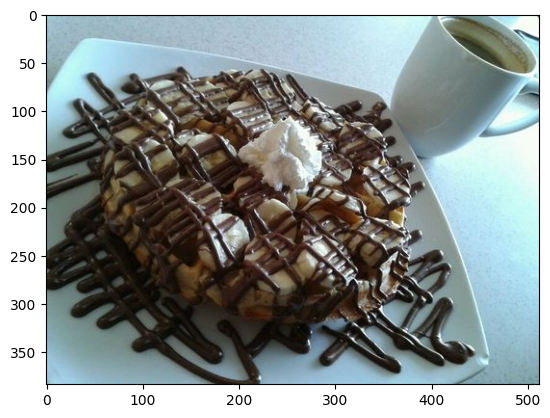

In [52]:
# Display an image. Brb. Gtg and get a waffle for myself. :P
testImg = imread('/content/food-101/test/waffles/1236559.jpg')
print(testImg.shape)
plt.imshow(testImg)


In [ ]:
X_train, y_train, X_test, y_test = load_train_test_data('/content/food-101/train','/content/food-101/test')

In [ ]:
tensorflow.keras.backend.clear_session()

n_classes = 101
batch_size = 16
width, height = 200, 200
train_data = '/content/food-101/train'
test_data = '/content/food-101/test'
train_samples = 75750
test_samples = 25250

train_data_gen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = train_data_gen.flow_from_directory(train_data, target_size=(height, width), batch_size=batch_size, class_mode='categorical')

test_gen = test_data_gen.flow_from_directory(test_data, target_size=(height, width), batch_size=batch_size, class_mode='categorical')

inception = InceptionV3(weights='imagenet', include_top=False)
layer = inception.output
layer = GlobalAveragePooling2D()(layer)
layer = Dense(128,activation='relu')(layer)
layer = Dropout(0.2)(layer)

predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(layer)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_101class.hdf5', save_best_only=True)
csv_logger = CSVLogger('history_101class.log')

history_101class = model.fit(train_gen, steps_per_epoch= train_samples // batch_size, validation_data= test_gen, validation_steps= test_samples // batch_size, epochs=30, callbacks=[csv_logger, checkpointer])

model.save('model_trained_101class.hdf5')

In [ ]:

class_map_101 = train_gen.class_indices
class_map_101

In [ ]:

# Plot training-accuracy & validation-accuracy.
_ = plt.style.library['seaborn-darkgrid']
_ = plt.title('FOOD_CLASSIFICATION-Inceptionv3')
_ = plt.plot(history_101class.history['accuracy'], marker='o', linestyle='dashed')
_ = plt.plot(history_101class.history['val_accuracy'], marker='x', linestyle='dashed')
_ = plt.ylabel('Accuracy')
_ = plt.xlabel('Epoch')
_ = plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
plt.show()

In [ ]:

# Plot training-loss & validation-loss.
_ = plt.style.library['seaborn-darkgrid']
_ = plt.title('FOOD_CLASSIFICATION-Inceptionv3')
_ = plt.plot(history_101class.history['loss'], marker='o', linestyle='dashed')
_ = plt.plot(history_101class.history['val_loss'], marker='x', linestyle='dashed')
_ = plt.ylabel('Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend(['train_loss', 'validation_loss'], loc='best')
plt.show()


In [ ]:
# Loading the best saved model to make predictions.
tensorflow.keras.backend.clear_session()
model_best = load_model('best_model_101class.hdf5',compile = False)
# Downloading some test images.
!wget -O cupcakes.jpg https://cdn.sallysbakingaddiction.com/wp-content/uploads/2019/05/yellow-cupcakes-with-chocolate-frosting-sprinkles.jpg
!wget -O frenchfries.jpg https://www.corriecooks.com/wp-content/uploads/2018/08/Instant-Pot-French-Fries.jpg
!wget -O pizza.jpg https://i.kinja-img.com/gawker-media/image/upload/s--ZkdkfWZf--/c_scale,f_auto,fl_progressive,q_80,w_800/lkw9iemetd2vpfggrard.jpg
!wget -O garlicbread.jpg https://thebusybaker.ca/wp-content/uploads/2018/08/easy-homemade-garlic-bread-3.jpg
!wget -O strawberryshortcake.jpg https://www.cookingclassy.com/wp-content/uploads/2019/03/strawberry-shortcake-02.jpg
!wget -O speghetticarbonara.jpg https://food.fnr.sndimg.com/content/dam/images/food/fullset/2015/12/1/3/WU1207H_Spaghetti-Carbonara_s4x3.jpg.rend.hgtvcom.826.620.suffix/1452882192060.jpeg

In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(200, 200))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.

    pred = model.predict(img)
    index = np.argmax(pred)
    foods_sorted.sort()
    pred_value = foods_sorted[index]
    if show:
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

images = ['cupcakes.jpg', 'pizza.jpg', 'frenchfries.jpg', 'garlicbread.jpg', 'strawberryshortcake.jpg', 'speghetticarbonara.jpg']
predict_class(model_best, images, True)

In [ ]:
def deprocess_img(tensor):
    # normalize tensor, map between [0,1] & transform to RGB array
    tensor = tensor - tensor.mean()
    tensor = tensor / (tensor.std() + 1e-5)
    tensor = tensor * 0.1
    tensor = tensor + 0.5
    tensor = np.clip(tensor, 0, 1)
    tensor = tensor * 255
    tensor = np.clip(tensor, 0, 255).astype('uint8')
    return tensor

def gen_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = tensorflow.keras.backend.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    gradient = tensorflow.keras.backend.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    gradient = gradient / (tensorflow.keras.backend.sqrt(tensorflow.keras.backend.mean(tensorflow.keras.backend.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = tensorflow.keras.backend.function([model.input], [loss, gradient])

    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, gradients_value = iterate([input_img_data])
        ip_img_data += gradients_value * step

    img = ip_img_data[0]
    return deprocess_img(img)

def get_activations(img, model_activations):
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.
    #plt.imshow(img[0])
    #plt.show()
    return model_activations.predict(img)

def show_activations(activations, layers):
    imgs_per_row = 16

    # Now let's display our feature maps
    for layer_name, layer_act in zip(layers, activations):
        # This is the number of features in the feature map
        n_feats = layer_act.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_act.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_feats // imgs_per_row
        show_grid = np.zeros((size * n_cols, imgs_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(imgs_per_row):
                channel_img = layer_act[0, :, :, col * imgs_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_img = channel_img - channel_img.mean()
                channel_img = channel_img / channel_img.std()
                channel_img = channel_img * 64
                channel_img = channel_img + 128
                channel_img = np.clip(channel_img, 0, 255).astype('uint8')
                show_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_img

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * show_grid.shape[1], scale * show_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(show_grid, aspect='auto', cmap='viridis')

    plt.show()

# Method to display the Heatmap and Class Activation of an image.
def get_attribution(food):
    img = image.load_img(food, target_size=(200, 200))
    img = image.img_to_array(img)
    img = img / 255.
    f,ax = plt.subplots(1,3, figsize=(15,15))
    ax[0].imshow(img)

    img = np.expand_dims(img, axis=0)
    preds = model.predict(img)
    class_id = np.argmax(preds[0])
    ax[0].set_title("Image")
    class_output = model.output[:, class_id]
    last_conv_layer = model.get_layer("mixed10")

    grads = tensorflow.keras.backend.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = tensorflow.keras.backend.mean(grads, axis=(0, 1, 2))
    iterate = tensorflow.keras.backend.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([img])

    for i in range(2048):
        conv_layer_output_value[:, :, i] = conv_layer_output_value[:, :, i] * pooled_grads_value[i]
        heatmap = np.mean(conv_layer_output_value, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    ax[1].imshow(heatmap)
    ax[1].set_title("Heatmap")

    act_img = cv2.imread(food)
    heatmap = cv2.resize(heatmap, (act_img.shape[1], act_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(act_img, 0.7, heatmap, 0.3, 0)
    cv2.imwrite('classactivation.png', superimposed)
    img_act = image.load_img('classactivation.png', target_size=(200, 200))
    ax[2].imshow(img_act)
    ax[2].set_title("Class Activation Map")
    plt.show()
    return preds


In [ ]:
tensorflow.keras.backend.clear_session()
print("Loading the model..")
model = load_model('best_model_101class.hdf5',compile = False)
# Get model layers
layers = [layer.output for layer in model.layers[1:11]]
layer_names = []

activations_output = models.Model(inputs=model.input, outputs=layers)

for layer in model.layers[1:11]:
    layer_names.append(layer.name)

print(layer_names)
print(len(model.layers))

In [ ]:
# Get attributions
get_attribution('cupcakes.jpg')
# Show activation layers
show_activations(get_activations('cupcakes.jpg',activations_output), layer_names)